# Improve the cache for XSPEC absorption models

I noticed in the sherpa benchmarks that XSPEC model evaluation is by far the dominant time cost when fitting X-ray spectra. Here, I want to look specifically if we can come up with a more efficient way to cache the absorption models.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sherpa.astro.xspec.tests.test_xspec import get_xspec_models_with_exp_cache

In [2]:
mlist = get_xspec_models_with_exp_cache()

Before I start, it's worthwhile checking that I do not duplicate efforts, i.e. that the XSEPC model itself does not do the same type of caching internally. Thus, I'm going to run the model with the same input energy bins just once and then 100 times for different values of nh. With the cache that I envision, the runtime for those two scenarios will be almost identical.

As we can see below, for calling the XEPC model directly without any sherpa cache, the runtime time of running 100 times is approximately 100 times longer than running it once. I've tried that for all three models tested here, but only keep the output for one in this notebook.

In [3]:
x = np.arange(0.01, 10., 0.01)
xlo = x[:-1]
xhi = x[1:]

def run_model_once(mdl):
    mdl.calc.__wrapped__(mdl, (1.23,), xlo, xhi)

def run_model_n_times(mdl):
    for nh in np.linspace(0.1, 10, 100):
        mdl.calc.__wrapped__(mdl, (nh,), xlo, xhi)

In [4]:
mlist

[sherpa.astro.xspec.XSTBabs,
 sherpa.astro.xspec.XScabs,
 sherpa.astro.xspec.XSphabs]

In [5]:
%timeit run_model_once(mlist[0]())

tbvabs Version 2.3
Cosmic absorption with grains and H2, modified from
Wilms, Allen, & McCray, 2000, ApJ 542, 914-924
Questions: Joern Wilms
joern.wilms@sternwarte.uni-erlangen.de
joern.wilms@fau.de

http://pulsar.sternwarte.uni-erlangen.de/wilms/research/tbabs/

PLEASE NOTICE:
To get the model described by the above paper
you will also have to set the abundances:
   abund wilm

Note that this routine ignores the current cross section setting
as it always HAS to use the Verner cross sections as a baseline.
976 µs ± 254 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [6]:
%timeit run_model_n_times(mlist[0]())

72.4 ms ± 2.35 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [7]:
%timeit run_model_once(mlist[2]())

4.4 ms ± 605 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [8]:
%timeit run_model_n_times(mlist[2]())

The slowest run took 4.12 times longer than the fastest. This could mean that an intermediate result is being cached.
544 ms ± 398 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Test difference ways to implement the cache

To do those tests, we define class for each of our cache implementations. We want that class to hold the intermediate data so that we can inspect it for debugging and we make that class a simple as possible. Unlike the real cache, there will be no dictionary of values and no lookup and we'll just one for one array of energy values. We simply set up the cache and then evaluate if for different values of N_H and see how well it performs compared to the original model.

### Try a cache with one canonical N_H value

In [9]:
class OneNH:
    def __init__(self, mdl, x, nh = 0.1):
        self.mdl = mdl()
        self.xlo = x[:-1]
        self.xhi = x[1:]
        self.nh = nh
        self.cache = np.log(self.mdl.calc.__wrapped__(self.mdl, (self.nh,), self.xlo, self.xhi))

    def __call__(self, nh):
        original = self.mdl.calc.__wrapped__(self.mdl, (nh,), self.xlo, self.xhi)
        cached = np.exp(nh / self.nh * self.cache)
        return original, cached
        

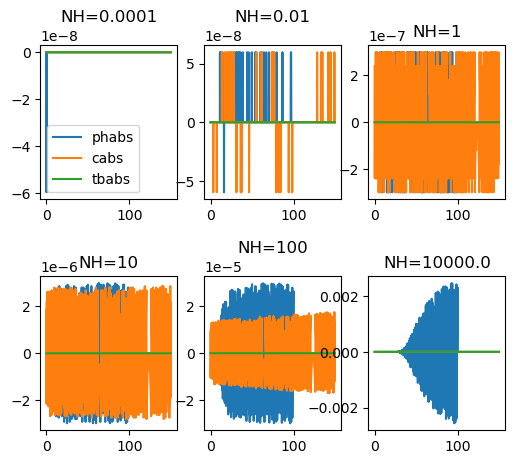

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(6, 5))

x = np.arange(0.001, 150, 0.1)


caches = [OneNH(mdl, x, nh=0.1) for mdl in mlist]

for nh, ax in zip([1e-4, 1e-2, 1, 10, 100, 1e4], axes.flat):
    for cache in reversed(caches):
        direct, withcache = cache(nh)
        ax.plot(x[:-1], direct - withcache, label=cache.mdl.name)
        ax.set_title(f'NH={nh}')
    
axes[0, 0].legend()
fig.subplots_adjust(hspace=0.5)

I redid the plot above interactively for a few times, using different values for the canonical nh that the cache is normalized to. I find that the first five panels all behave in the same way: The larger the nh used to calculate the cache value, the better the numerical precision for a large energy range. However, for very small nh values and low energies it begins to fail. The last panel is different: The error in phabs is constant. That can only mean that the error is in the XSPEC model itself and there is nothing we can do about it.

So, I want to look at information for different canonical values of nh now to choose which one we should be using.

The following cell tried out different values for the canonical nh and lists the energy values for which the interpolation does not work (because the intermediate values are np.inf). In practice, we should set the limit a bit larger than that, because the exact values covered will depend on the bin boundaries used for this test.

In [11]:
x = np.logspace(-3, 0, 100)
for nh in [0.001, 0.01, 0.1, 1]:
    print(f"NH={nh}")
    caches = [OneNH(mdl, x, nh=nh) for mdl in mlist]
    for c in caches:
        ind_inf = np.isinf(c.cache)
        if ind_inf.sum() > 0:
            print(f"{c.mdl.name}: {c.xlo[ind_inf].min():6.4f} - {c.xhi[ind_inf].max():6.4f}")


NH=0.001
NH=0.01
phabs: 0.0142 - 0.0327
NH=0.1
tbabs: 0.0132 - 0.0376
phabs: 0.0142 - 0.0811
NH=1
tbabs: 0.0132 - 0.0933
phabs: 0.0142 - 0.1874


So, to work well for all energies, we need to use a canonical nh < 0.01. However, for a number this small, we have to worry about the numerical precision that will introduces unacceptably large errors for NH values > 1, which do happen in real astrophysical fitting.

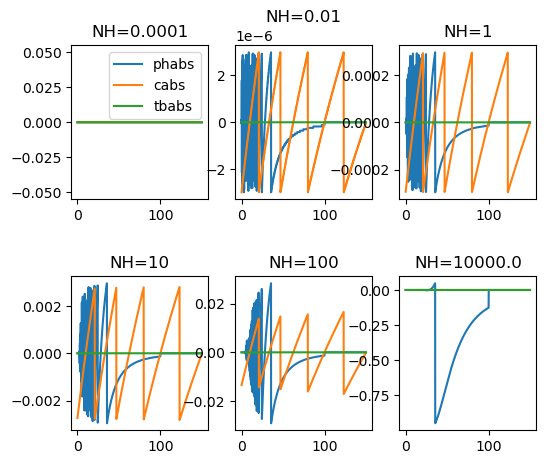

In [12]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(6, 5))

x = np.arange(0.001, 150, 0.1)


caches = [OneNH(mdl, x, nh=0.0001) for mdl in mlist]

for nh, ax in zip([1e-4, 1e-2, 1, 10, 100, 1e4], axes.flat):
    for cache in reversed(caches):
        direct, withcache = cache(nh)
        ax.plot(x[:-1], direct - withcache, label=cache.mdl.name)
        ax.set_title(f'NH={nh}')
    
axes[0, 0].legend()
fig.subplots_adjust(hspace=0.5)

### Try a cache with multiple canonical N_H values

In [13]:
def one_nh_vals(mdl):
    a = mdl.calc.__wrapped__(mdl, (nh,), xlo, xhi)

def two_nh_vals(mdl):
    a = mdl.calc.__wrapped__(mdl, (nh,), xlo[:10], xhi[:10])
    b = mdl.calc.__wrapped__(mdl, (.1,), xlo[10:], xhi[10:])



It's clearly a trade-off between making this code efficient (don't call it more often to make the cash then you would to use the cache) and making it safe for every situation. I'm attempting to bridge that gap but cutting into energy ranges that applicable for common instruments, e.g. XMM and Chandra. The cache is applied "per dataset" so we need not worry about joint fitting; but we do need to design the cache to work for every possible energy range and to be efficient for common energy ranges.

In [14]:
%timeit one_nh_vals(mlist[1]())

29.8 µs ± 378 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [15]:
%timeit two_nh_vals(mlist[1]())

32.2 µs ± 686 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


Splitting the call to the original model into two parts has different effects on the different model (I tried it for all three, but kept the output only for one in the cells above).

- For XSTBabs, runtimes are almost identical.
- For XScabs and XSPhabs, runtime almost doubles.

Even if it doubles, the cache still pays off if the model is used more than twice, but it risks a 50% performance hit, if the cache is not hit at all. 

Fitting is the most speed-critical process, in a single call to, e.g. plot a model, the extra cost of 150 microseconds is not a problem (and even then it's likely that the model has been used for fitting before and the cache is already built).

In [16]:
class MultiNH:
    def __init__(self, mdl, x, nh = [0.1], nh_bound = [np.inf]):
        '''Splitting on the energy values for the lower bound of the bins.
        
        The low-energy part is the more critical one (we get infs), while
        for higher energies the numerical precision increases very slowly,
        so it's more important to keep the low-energy part accurate.
        '''
        if not len(nh_bound) == len(nh):
            raise ValueError(f"For {len(nh)} NH values, there should be {len(nh)} bound values")
        self.mdl = mdl()
        self.xlo = x[:-1]
        self.xhi = x[1:]
        self.nh_bound = nh_bound
        self.nh = np.asanyarray(nh)
        nhbin = np.digitize(self.xlo, nh_bound)
        self.cache = np.zeros_like(self.xlo, dtype=float)
        for i, this_nh in enumerate(nh):
            ind = nhbin == i
            if ind.sum() == 0:
                continue
            # XSPEC models needs to be called with at least two energy bins.
            # If the split is such that we have only one bin, we need to
            # work around that.
            if ind.sum() == 1:
                xlo = np.append(self.xlo[ind], self.xhi[ind])
                xhi = np.append(self.xhi[ind], self.xhi[ind] + 0.01)
                use_xpec_out = [True, False]
            else:
                xlo = self.xlo[ind]
                xhi = self.xhi[ind]
                use_xpec_out = np.ones_like(xlo, dtype=bool)

            xspecout = np.log(self.mdl.calc.__wrapped__(self.mdl, (this_nh,), xlo, xhi))
            self.cache[ind] = xspecout[use_xpec_out]

    def __call__(self, nh):
        original = self.mdl.calc.__wrapped__(self.mdl, (nh,), self.xlo, self.xhi)
        nh_arr = self.nh[np.digitize(self.xlo, self.nh_bound)]
        cached = np.exp(nh / nh_arr * self.cache)
        return original, cached

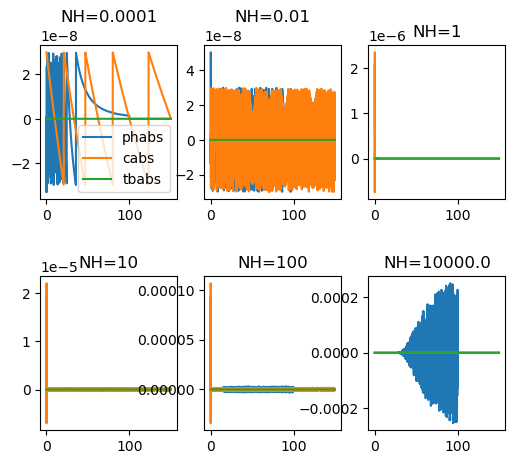

In [18]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(6, 5))

x = np.arange(0.001, 150, 0.1)


caches = [MultiNH(mdl, x, nh=[0.01, 1.], nh_bound=[0.3, np.inf]) for mdl in mlist]

for nh, ax in zip([1e-4, 1e-2, 1, 10, 100, 1e4], axes.flat):
    for cache in reversed(caches):
        direct, withcache = cache(nh)
        ax.plot(x[:-1], direct - withcache, label=cache.mdl.name)
        ax.set_title(f'NH={nh}')
    
axes[0, 0].legend()
fig.subplots_adjust(hspace=0.5)

Now, list area where the cache won't work because the value is not finite.

In [19]:
x = np.logspace(-3, 0, 1000)
caches = [MultiNH(mdl, x, nh=[0.001, 1.], nh_bound=[0.2, np.inf]) for mdl in mlist]

for nh in [0.001, 0.01, 0.1, 1]:
    print(f"NH={nh}")
    for c in caches:
        ind_inf = np.isinf(c.cache)
        if ind_inf.sum() > 0:
            print(f"{c.mdl.name}: {c.xlo[ind_inf].min():6.4f} - {c.xhi[ind_inf].max():6.4f}")


NH=0.001
NH=0.01
NH=0.1
NH=1


As we see, with this setting, there are not problem areas (othwerwise they would be listed above).

In [20]:
mlist

[sherpa.astro.xspec.XSTBabs,
 sherpa.astro.xspec.XScabs,
 sherpa.astro.xspec.XSphabs]

In [21]:
from sherpa.astro import xspec


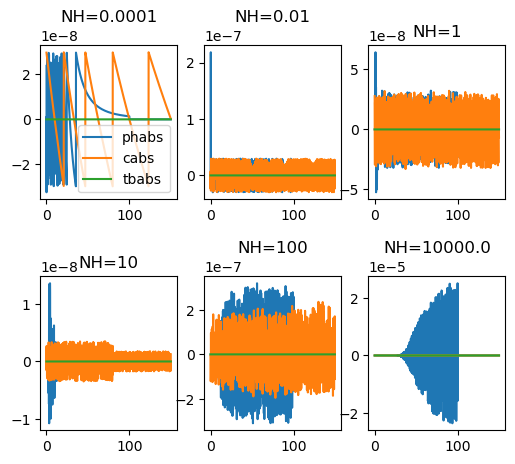

In [22]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(6, 5))

x = np.arange(0.001, 150, 0.1)

caches = [MultiNH(xspec.XSTBabs, x, nh=[0.001, 1.], nh_bound=[0.1, np.inf]),
          MultiNH(xspec.XScabs, x, nh=[10], nh_bound=[np.inf]),
          MultiNH(xspec.XSphabs, x, nh=[0.001, 10.], nh_bound=[0.5, np.inf])]


for nh, ax in zip([1e-4, 1e-2, 1, 10, 100, 1e4], axes.flat):
    for cache in reversed(caches):
        direct, withcache = cache(nh)
        ax.plot(x[:-1], direct - withcache, label=cache.mdl.name)
        ax.set_title(f'NH={nh}')
    
axes[0, 0].legend()
fig.subplots_adjust(hspace=0.5)

In [23]:
x = np.logspace(-3, 0, 1000)

caches = [MultiNH(xspec.XSTBabs, x, nh=[0.001, 1.], nh_bound=[0.1, np.inf]),
          MultiNH(xspec.XScabs, x, nh=[10], nh_bound=[np.inf]),
          MultiNH(xspec.XSphabs, x, nh=[0.001, 10.], nh_bound=[0.5, np.inf])]

for nh in [0.001, 0.01, 0.1, 1]:
    print(f"NH={nh}")
    for c in caches:
        ind_inf = np.isinf(c.cache)
        if ind_inf.sum() > 0:
            print(f"{c.mdl.name}: {c.xlo[ind_inf].min():6.4f} - {c.xhi[ind_inf].max():6.4f}")


NH=0.001
NH=0.01
NH=0.1
NH=1
